# 🤖 MODELAGEM DE MACHINE LEARNING PARA SCORE DE CRÉDITO

**Objetivo:** Desenvolver, avaliar e selecionar modelos de Machine Learning para prever a inadimplência de clientes.

### 📌 Etapas do Projeto
- Reparar dados para Machine Learning
- Codificar variáveis categóricas
- Dividir em treino e teste
- Treinar múltiplos modelos de classificação
- Avaliar performance com métricas adequadas
- Selecionar melhor modelo
- Analisar feature importance
- Salvar modelo para produção

### 🏆 Modelo que vamos testar
- Random Forest (Ensemble)
- KNN (K-Nearest Neighbors)
- Logistic Regression (Linear)
- Decision-Tree (Base do Random Forest)

In [60]:
# CÉLULA 1. IMPORTAÇÃO DE BIBLIOTECAS
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Para salvar modelos
from datetime import datetime
import os
import json
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay
)

# Configs de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
%matplotlib inline

In [ ]:
# CÉLULA 2. CARREGANDO DADOS DO SQLITE
DB_PATH = '..data/database.db'
print(f"\n📂 Carregando dados: {DB_PATH}")

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM clientes", conn)
conn.close()


📂 Carregando dados: data/database.db


In [62]:
# CÉLULA 3. CODIFICANDO VARIÁVEIS CATEGÓRICAS
print("🔄 CODIFICANDO VARIÁVEIS CATEGÓRICAS")

# Identifica
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'inadimplente' in cat_cols:
  cat_cols.remove('inadimplente')

print(f"\n📝 Variáveis categóricas: {cat_cols}")

# Codifica e salva encoders
encoders = {}

os.makedirs('../models', exist_ok=True)

for col in cat_cols:
  encoder = LabelEncoder()
  df[col] = encoder.fit_transform(df[col])
  encoders[col] = encoder
    
  joblib.dump(encoder, f'../models/encoder_{col}.pkl')
  print(f"   ✅ {col}: {list(encoder.classes_)}")

print(f"\n💾 {len(encoders)} encoders salvos em ../models/")

🔄 CODIFICANDO VARIÁVEIS CATEGÓRICAS

📝 Variáveis categóricas: ['genero', 'estado_civil', 'escolaridade', 'estado', 'ocupacao']
   ✅ genero: ['F', 'M']
   ✅ estado_civil: ['Casado', 'Divorciado', 'Solteiro', 'Viúvo']
   ✅ escolaridade: ['Fundamental', 'Médio', 'Pós-graduação', 'Superior']
   ✅ estado: ['BA', 'CE', 'GO', 'MG', 'PE', 'PR', 'RJ', 'RS', 'SC', 'SP']
   ✅ ocupacao: ['Autônomo', 'CLT', 'Desempregado', 'Empresário']

💾 5 encoders salvos em ../models/


In [63]:
# CÉLULA 4. PREPARANDO X e Y
print("✂️ SEPARANDO FEATURES (X) E TARGET (y)")

# Remove ID (coluna desnecessária) e Target (Principal)
X = df.drop(columns=['id_cliente', 'inadimplente'])
y = df['inadimplente']

print(f"\n📊 X: {X.shape} - {X.shape[1]} features")
print(f"📊 y: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

✂️ SEPARANDO FEATURES (X) E TARGET (y)

📊 X: (100000, 15) - 15 features
📊 y: (100000,)

Features: ['idade', 'genero', 'estado_civil', 'escolaridade', 'estado', 'renda_anual', 'valor_patrimonio', 'possui_imovel_proprio', 'possui_carro', 'ocupacao', 'numero_dependentes', 'tempo_emprego_atual', 'score_serasa_externo', 'utilizacao_limite_cartao', 'historico_atraso_90_dias']


In [64]:
# CÉLULA 5. DIVIDIR TREINO/TESTE
print("🔀 TREINO/TESTE (70/30)")

X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.3,
  random_state=42,
  stratify=y
)

print(f"\n✅ Treino: {len(X_train):,} ({len(X_train)/len(X)*100:.0f}%)")
print(f"✅ Teste:  {len(X_test):,} ({len(X_test)/len(X)*100:.0f}%)")
print(f"\nTaxa inadimplência treino: {y_train.mean()*100:.2f}%")
print(f"Taxa inadimplência teste:  {y_test.mean()*100:.2f}%")

🔀 TREINO/TESTE (70/30)

✅ Treino: 70,000 (70%)
✅ Teste:  30,000 (30%)

Taxa inadimplência treino: 19.20%
Taxa inadimplência teste:  19.20%


In [65]:
# CÉLULA 6. NORMALIZAÇÃO (KNN e LR)
print("⚖️ NORMALIZAÇÃO (StandardScaler)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converte de volta para DataFrame
X_train_scaled = pd.DataFrame(
  X_train_scaled,
  columns=X.columns,
  index=X_train.index
)

X_test_scaled = pd.DataFrame(
  X_test_scaled,
  columns=X.columns,
  index=X_test.index
)

print("✅ Dados normalizados (média=0, std=1)")
joblib.dump(scaler, '../models/scaler.pkl')
print("💾 Scaler salvo em ../models/scaler.pkl")

⚖️ NORMALIZAÇÃO (StandardScaler)
✅ Dados normalizados (média=0, std=1)
💾 Scaler salvo em ../models/scaler.pkl


In [66]:
# CÉLULA 7. TREINAR MODELOS
print("🤖 TREINANDO MODELOS")

modelos = {}

# ──────────────────────────────────────────────────────────────────────────
# RANDOM FOREST
# ──────────────────────────────────────────────────────────────────────────
print("\n1️⃣ Random Forest...")
modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # IMPORTANTE: lida com desbalanceamento
)
modelo_rf.fit(X_train, y_train)
modelos['Random Forest'] = modelo_rf
print("✅ Treinado (SEM normalização)")

# ──────────────────────────────────────────────────────────────────────────
# LOGISTIC REGRESSION
# ──────────────────────────────────────────────────────────────────────────
print("\n2️⃣ Logistic Regression...")
modelo_lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
modelo_lr.fit(X_train, y_train)
modelos['Logistic Regression'] = modelo_lr
print("✅ Treinado (COM normalização)")

# ──────────────────────────────────────────────────────────────────────────
# KNN (K-Nearest Neighbors)
# ──────────────────────────────────────────────────────────────────────────
print("\n3️⃣ KNN...")
modelo_knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    n_jobs=-1
)
modelo_knn.fit(X_train_scaled, y_train)
modelos['KNN'] = modelo_knn
print("✅ Treinado (COM normalização)")


🤖 TREINANDO MODELOS

1️⃣ Random Forest...
✅ Treinado (SEM normalização)

2️⃣ Logistic Regression...
✅ Treinado (COM normalização)

3️⃣ KNN...
✅ Treinado (COM normalização)


In [ ]:
# CÉLULA 8. COMPARAÇÃO ENTRE MODELOS
print("🌲 COMPARAÇÃO COM RANDOM FOREST")

# Logistic Regression
y_pred_lr  = modelo_lr.predict(X_test_scaled)
y_proba_lr = modelo_lr.predict_proba(X_test_scaled)[:, 1]

# Random Forest
y_pred_rf  = modelo_rf.predict(X_test)
y_proba_rf = modelo_rf.predict_proba(X_test)[:, 1]

print(f"\n{'Métrica':<15} {'Log Regression':<18} {'Random Forest':<18}")
print("-"*80)

lr_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'AUC-ROC': roc_auc_score(y_test, y_proba_lr)
}

rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'AUC-ROC': roc_auc_score(y_test, y_proba_rf)
}

for metric in lr_metrics:
    print(f"{metric:<15} {lr_metrics[metric]:<18.4f} {rf_metrics[metric]:<18.4f}")

melhoria_auc = (
    (rf_metrics['AUC-ROC'] - lr_metrics['AUC-ROC'])
    / lr_metrics['AUC-ROC']
) * 100

print(f"\n✓ Random Forest melhorou AUC em {melhoria_auc:.1f}%")
print("✓ Mantemos Logistic Regression por interpretabilidade")

In [ ]:
# CÉLULA 9. PREVISÕES
print("🔮 FAZENDO PREVISÕES")

previsoes = {}
probabilidades = {}

# RF (sem normalização)
previsoes['Random Forest'] = modelo_rf.predict(X_test)
probabilidades['Random Forest'] = modelo_rf.predict_proba(X_test)[:, 1]

# LR (com normalização)
previsoes['Logistic Regression'] = modelo_lr.predict(X_test_scaled)
probabilidades['Logistic Regression'] = modelo_lr.predict_proba(X_test_scaled)[:, 1]

# KNN (com normalização)
previsoes['KNN'] = modelo_knn.predict(X_test_scaled)
probabilidades['KNN'] = modelo_knn.predict_proba(X_test_scaled)[:, 1]

🔮 FAZENDO PREVISÕES


In [ ]:
# CÉLULA 10. AVALIANDO MODELOS - MÉTRICAS COMPLETAS
print("📊 AVALIAÇÃO DOS MODELOS")

"""
IMPORTANTE: Em crédito, RECALL é mais importante que ACCURACY!

Por quê?
- Accuracy alta pode ser enganosa (prevê tudo como adimplente)
- RECALL mede: "dos inadimplentes reais, quantos detectamos?"
- Em crédito, NÃO detectar inadimplente é mais caro!

Métricas priorizadas:
1. Recall (classe inadimplente)
2. AUC-ROC (performance geral)
3. F1-Score (balanço)
"""

resultados = {}

for nome in modelos.keys():
    y_pred = previsoes[nome]
    y_prob = probabilidades[nome]
    
    # Calcula métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)  # ← MÉTRICA PRINCIPAL
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    resultados[nome] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,  # ← PRIORIDADE
        'F1-Score': f1,
        'AUC-ROC': auc  # ← MUITO IMPORTANTE EM CRÉDITO
    }
    
    print(f"\n{'═'*80}")
    print(f"📌 {nome}")
    print(f"{'═'*80}")
    print(f"   Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"   Precision: {prec:.4f} ({prec*100:.2f}%)")
    print(f"   Recall:    {rec:.4f} ({rec*100:.2f}%) ⭐ PRINCIPAL")
    print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    print(f"   AUC-ROC:   {auc:.4f} ({auc*100:.2f}%) ⭐ IMPORTANTE")
    
    print(f"\n💡 Interpretação:")
    print(f"• Detecta {rec*100:.0f}% dos inadimplentes reais")
    print(f"• Quando aprova, {prec*100:.0f}% são confiáveis")


📊 AVALIAÇÃO DOS MODELOS

════════════════════════════════════════════════════════════════════════════════
📌 Random Forest
════════════════════════════════════════════════════════════════════════════════
   Accuracy:  0.8130 (81.30%)
   Precision: 0.5114 (51.14%)
   Recall:    0.5843 (58.43%) ⭐ PRINCIPAL
   F1-Score:  0.5454 (54.54%)
   AUC-ROC:   0.8524 (85.24%) ⭐ IMPORTANTE

💡 Interpretação:
• Detecta 58% dos inadimplentes reais
• Quando aprova, 51% são confiáveis

════════════════════════════════════════════════════════════════════════════════
📌 Logistic Regression
════════════════════════════════════════════════════════════════════════════════
   Accuracy:  0.6001 (60.01%)
   Precision: 0.2765 (27.65%)
   Recall:    0.6695 (66.95%) ⭐ PRINCIPAL
   F1-Score:  0.3913 (39.13%)
   AUC-ROC:   0.6668 (66.68%) ⭐ IMPORTANTE

💡 Interpretação:
• Detecta 67% dos inadimplentes reais
• Quando aprova, 28% são confiáveis

═════════════════════════════════════════════════════════════════════════════

🏆 SELEÇÃO DO MELHOR MODELO

                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Logistic Regression  0.600067   0.276468  0.669502  0.391335  0.666824
Random Forest        0.812967   0.511395  0.584274  0.545410  0.852437
KNN                  0.804733   0.482408  0.230863  0.312280  0.711922

🏆 MELHOR MODELO: Logistic Regression
Recall: 0.6695 (66.95%)
AUC-ROC: 0.6668 (66.68%)

💡 Escolhido por RECALL (detectar inadimplentes é prioridade!)


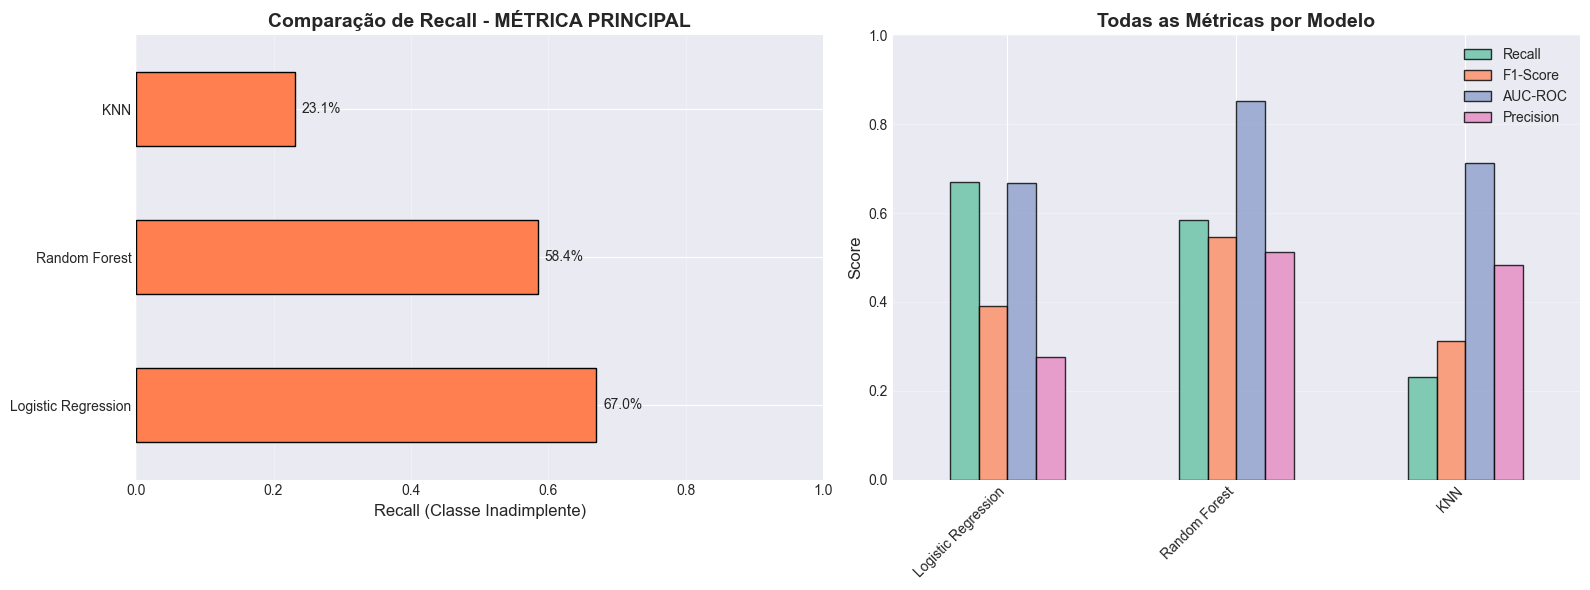

In [ ]:
# CÉLULA 11. MELHOR MODELO (POR RECALL)
print("🏆 SELEÇÃO DO MELHOR MODELO")

df_resultados = pd.DataFrame(resultados).T

# ORDENA POR RECALL
df_resultados = df_resultados.sort_values('Recall', ascending=False)

print(f"\n{df_resultados.to_string()}")

# Melhor modelo
melhor_modelo = df_resultados.index[0]
melhor_recall = df_resultados.iloc[0]['Recall']
melhor_auc = df_resultados.iloc[0]['AUC-ROC']

print(f"\n🏆 MELHOR MODELO: {melhor_modelo}")
print(f"Recall: {melhor_recall:.4f} ({melhor_recall*100:.2f}%)")
print(f"AUC-ROC: {melhor_auc:.4f} ({melhor_auc*100:.2f}%)")
print(f"\n💡 Escolhido por RECALL (detectar inadimplentes é prioridade!)")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Comparação de Recall
df_resultados['Recall'].plot(
    kind='barh', ax=axes[0], color='coral', edgecolor='black'
)
axes[0].set_xlabel('Recall (Classe Inadimplente)', fontsize=12)
axes[0].set_title('Comparação de Recall - MÉTRICA PRINCIPAL', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim([0, 1])

for i, v in enumerate(df_resultados['Recall']):
    axes[0].text(v + 0.01, i, f'{v:.1%}', va='center')

# Todas as métricas
df_resultados[['Recall', 'F1-Score', 'AUC-ROC', 'Precision']].plot(
    kind='bar', ax=axes[1], alpha=0.8, edgecolor='black'
)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Todas as Métricas por Modelo', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend(loc='upper right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

📈 CURVA ROC E AUC 👇


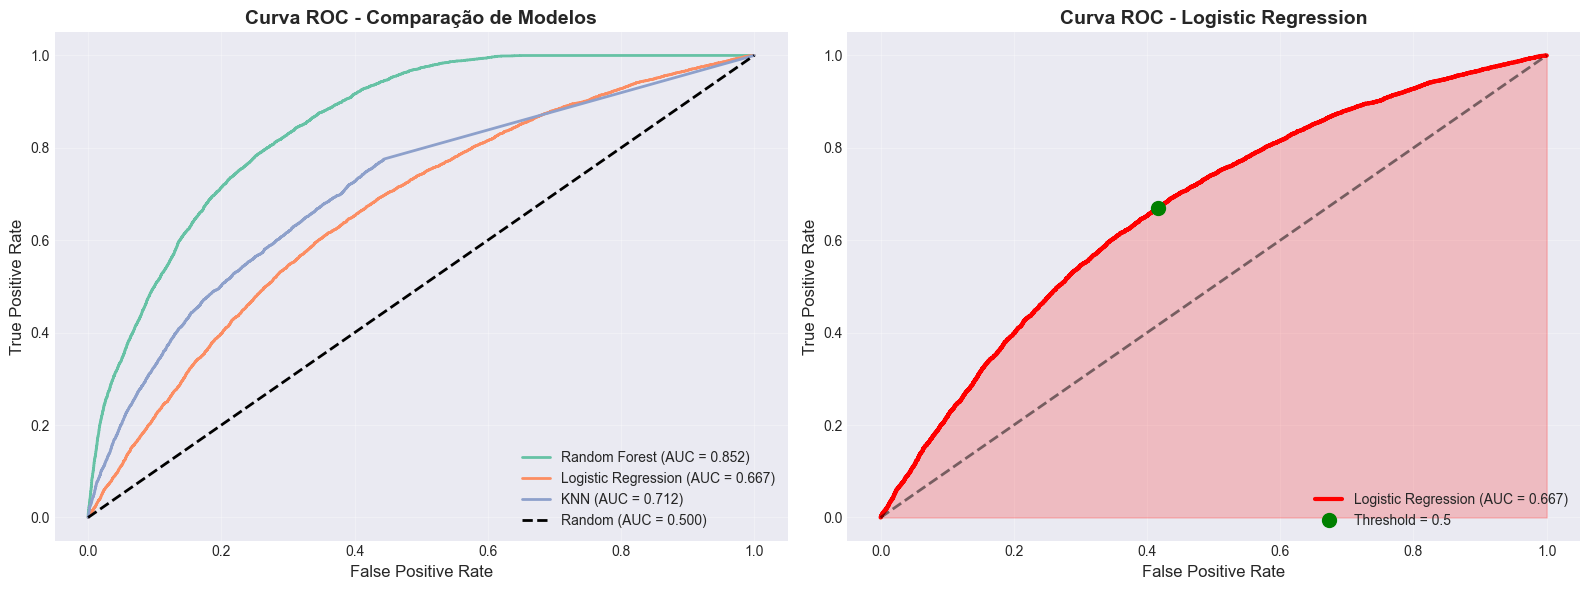


📊 AUC (Area Under Curve):
Random Forest            : 0.8524 🟢 EXCELENTE
Logistic Regression      : 0.6668 🟠 ACEITÁVEL
KNN                      : 0.7119 🟡 BOM


In [ ]:
# CÉLULA 12. CURVA ROC e AUC (OBRIGATÓRIO EM CRÉDITO!)
print("📈 CURVA ROC E AUC 👇")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

"""
ROC (Receiver Operating Characteristic):
- Mostra trade-off entre True Positive Rate e False Positive Rate
- AUC (Area Under Curve): resumo em um número (0.5 a 1.0)
- AUC > 0.8: Excelente
- AUC > 0.7: Bom
- AUC > 0.6: Aceitável
- AUC = 0.5: Random (inútil)

Vantagem: independe do threshold!
"""

# ──────────────────────────────────────────────────────────────────────────
# ROC de todos os modelos
# ──────────────────────────────────────────────────────────────────────────
for nome in modelos.keys():
    y_prob = probabilidades[nome]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = resultados[nome]['AUC-ROC']
    
    axes[0].plot(fpr, tpr, linewidth=2, 
                label=f'{nome} (AUC = {auc:.3f})')
    
# Random
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.500)')

axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('Curva ROC - Comparação de Modelos', 
                 fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# ──────────────────────────────────────────────────────────────────────────
# ROC do MELHOR modelo (detalhado)
# ──────────────────────────────────────────────────────────────────────────
y_prob_best = probabilidades[melhor_modelo]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
auc_best = resultados[melhor_modelo]['AUC-ROC']

axes[1].plot(fpr, tpr, linewidth=3, color='red', 
            label=f'{melhor_modelo} (AUC = {auc_best:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
axes[1].fill_between(fpr, tpr, alpha=0.2, color='red')

axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title(f'Curva ROC - {melhor_modelo}', 
                 fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

# Adiciona ponto do threshold 0.5
idx_05 = np.argmin(np.abs(thresholds - 0.5))
axes[1].plot(fpr[idx_05], tpr[idx_05], 'go', markersize=10, 
            label=f'Threshold = 0.5')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"\n📊 AUC (Area Under Curve):")
for nome, res in resultados.items():
    auc = res['AUC-ROC']
    if auc > 0.8:
        nivel = "🟢 EXCELENTE"
    elif auc > 0.7:
        nivel = "🟡 BOM"
    elif auc > 0.6:
        nivel = "🟠 ACEITÁVEL"
    else:
        nivel = "🔴 FRACO"
    print(f"{nome:25s}: {auc:.4f} {nivel}")

🎚️ ANÁLISE DE THRESHOLD (DECISÃO DE NEGÓCIO)

 Threshold  Precision   Recall  F1-Score  Taxa Aprovação
       0.3   0.193314 0.997743  0.323877        0.886667
       0.4   0.217576 0.923104  0.352150       18.526667
       0.5   0.276468 0.669502  0.391335       53.496667
       0.6   0.322924 0.389516  0.353108       76.836667
       0.7   0.344012 0.191981  0.246435       89.283333

💡 Interpretação:
• Threshold 0.3: Aprova mais (0.9%), mas mais risco
• Threshold 0.5: Padrão (53.5%)
• Threshold 0.7: Mais conservador (89.3%), menos risco


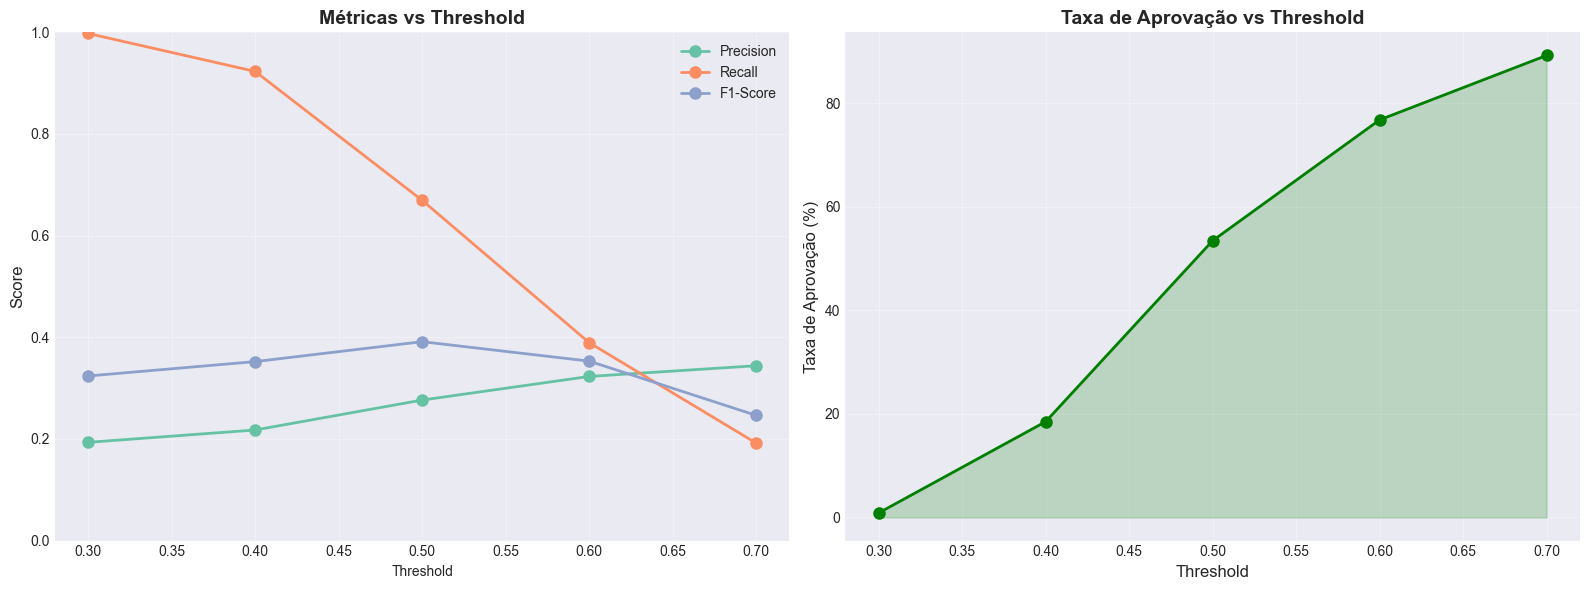

In [ ]:
# CÉLULA 13. ANÁLISE DE THRESHOLD
print("🎚️ ANÁLISE DE THRESHOLD (DECISÃO DE NEGÓCIO)")

"""
THRESHOLD = ponto de corte para classificar

Threshold 0.5 (padrão):
- Se prob > 0.5 → Inadimplente
- Se prob ≤ 0.5 → Adimplente

MAS em crédito, threshold é DECISÃO DE NEGÓCIO!

Threshold BAIXO (0.3):
✅ Aprova mais clientes
✅ Mais receita
❌ Mais risco

Threshold ALTO (0.7):
✅ Menos risco
✅ Mais precision
❌ Aprova menos (perde clientes bons)
"""

# Avaliação técnica refinada de thresholds
thresholds_finos = [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70]

print(f"\n{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
print("-"*50)

for t in thresholds_finos:
    y_pred_tmp = (y_prob_best >= t).astype(int)

    print(f"{t:<10.2f} "
          f"{precision_score(y_test, y_pred_tmp):<10.3f} "
          f"{recall_score(y_test, y_pred_tmp):<10.3f} "
          f"{f1_score(y_test, y_pred_tmp):<10.3f}")

# Testa diferentes thresholds
thresholds_teste = [0.3, 0.4, 0.5, 0.6, 0.7]
y_prob_best = probabilidades[melhor_modelo]

resultados_threshold = []

for threshold in thresholds_teste:
    # Aplica threshold
    y_pred_custom = (y_prob_best >= threshold).astype(int)
    
    # Calcula métricas
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    
    # Simula aprovação
    taxa_aprovacao = (y_pred_custom == 0).mean() * 100
    
    resultados_threshold.append({
        'Threshold': threshold,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Taxa Aprovação': taxa_aprovacao
    })

df_threshold = pd.DataFrame(resultados_threshold)
print(f"\n{df_threshold.to_string(index=False)}")

print(f"\n💡 Interpretação:")
print(f"• Threshold 0.3: Aprova mais ({df_threshold.iloc[0]['Taxa Aprovação']:.1f}%), mas mais risco")
print(f"• Threshold 0.5: Padrão ({df_threshold.iloc[2]['Taxa Aprovação']:.1f}%)")
print(f"• Threshold 0.7: Mais conservador ({df_threshold.iloc[4]['Taxa Aprovação']:.1f}%), menos risco")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Métricas vs Threshold
df_threshold.plot(x='Threshold', y=['Precision', 'Recall', 'F1-Score'],
                 ax=axes[0], marker='o', linewidth=2, markersize=8)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Métricas vs Threshold', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_ylim([0, 1])

# Taxa de Aprovação vs Threshold
axes[1].plot(df_threshold['Threshold'], df_threshold['Taxa Aprovação'],
            marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Taxa de Aprovação (%)', fontsize=12)
axes[1].set_title('Taxa de Aprovação vs Threshold', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].fill_between(df_threshold['Threshold'], df_threshold['Taxa Aprovação'], 
                     alpha=0.2, color='green')

plt.tight_layout()
plt.show()


🎯 MATRIZ DE CONFUSÃO


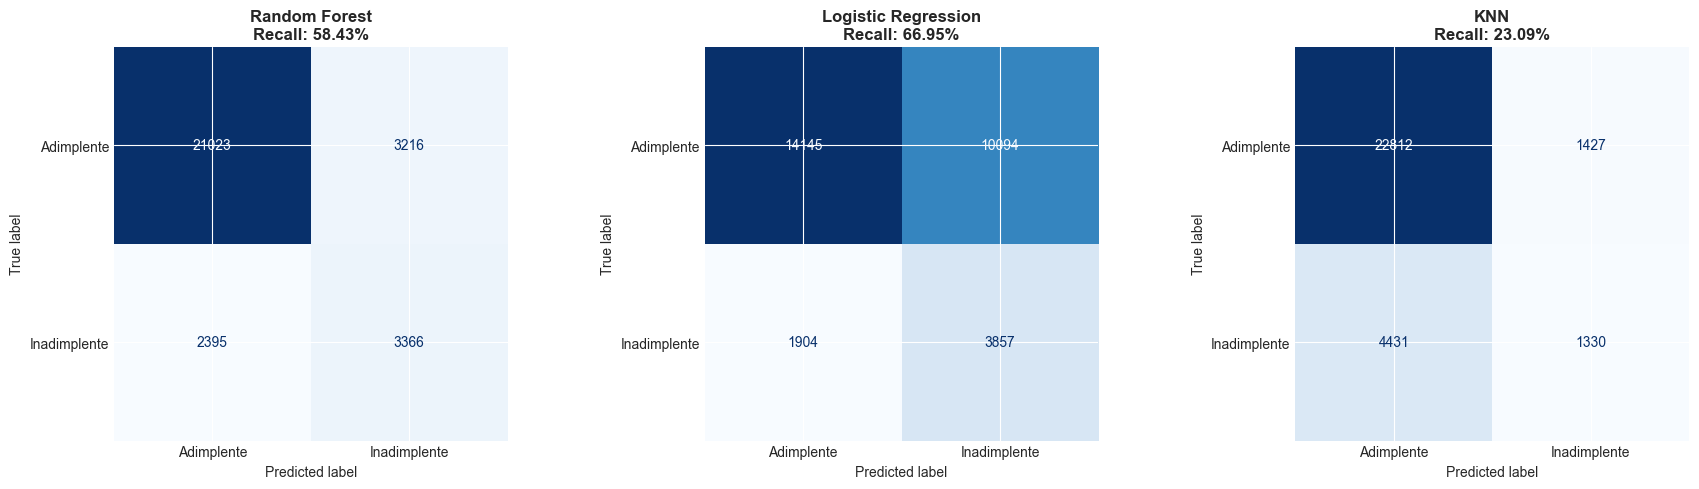


📌 Matriz de Confusão - Logistic Regression:
────────────────────────────────────────────────────────────
VN (Verdadeiro Negativo):  14,145 ← Previu adimplência e era
FP (Falso Positivo):       10,094 ← Previu inadimplência mas era adimlência
FN (Falso Negativo):        1,904 ← Previu adimplência mas era inadimplência ⚠️
VP (Verdadeiro Positivo):   3,857 ← Previu inadimplência e era ✅


In [ ]:
# CÉLULA 14. MATRIZ DE CONFUSÃO
print("🎯 MATRIZ DE CONFUSÃO")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, nome in enumerate(modelos.keys()):
    cm = confusion_matrix(y_test, previsoes[nome])
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Adimplente', 'Inadimplente']
    )
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d', colorbar=False)
    
    recall = resultados[nome]['Recall']
    axes[idx].set_title(f'{nome}\nRecall: {recall:.2%}', 
                       fontsize=12, fontweight='bold')
    
plt.tight_layout()
plt.show()


# Matriz do melhor modelo (DETALHADA!)
cm_best = confusion_matrix(y_test, previsoes[melhor_modelo])
print(f"\n📌 Matriz de Confusão - {melhor_modelo}:")
print(f"{'─'*60}")
print(f"VN (Verdadeiro Negativo):  {cm_best[0,0]:>6,} ← Previu adimplência e era")
print(f"FP (Falso Positivo):       {cm_best[0,1]:>6,} ← Previu inadimplência mas era adimlência")
print(f"FN (Falso Negativo):       {cm_best[1,0]:>6,} ← Previu adimplência mas era inadimplência ⚠️")
print(f"VP (Verdadeiro Positivo):  {cm_best[1,1]:>6,} ← Previu inadimplência e era ✅")

# Atenção especial ao Falso Negativo (FN), pois representa clientes inadimplentes classificados como adimplentes — erro de alto custo financeiro.

In [ ]:
# CÉLULA 15. CROSS-VALIDATION
print("🔄 CROSS-VALIDATION (5-FOLD)")

# CV apenas no melhor modelo para economizar tempo
modelo_cv = modelos[melhor_modelo]

if melhor_modelo == 'Logistic Regression':
    X_cv = X_train_scaled
else:
    X_cv = X_train

print(f"\n⏳ Validando {melhor_modelo}...")

# CV com 5 folds
scores_recall = cross_val_score(modelo_cv, X_cv, y_train, 
                                cv=5, scoring='recall')
scores_auc = cross_val_score(modelo_cv, X_cv, y_train, 
                             cv=5, scoring='roc_auc')

print(f"\n📊 Recall (5 folds): {[f'{s:.4f}' for s in scores_recall]}")
print(f"Média: {scores_recall.mean():.4f} ± {scores_recall.std():.4f}")

print(f"\n📊 AUC-ROC (5 folds): {[f'{s:.4f}' for s in scores_auc]}")
print(f"Média: {scores_auc.mean():.4f} ± {scores_auc.std():.4f}")

# Considera o modelo estável se o desvio padrão do Recall
# e do AUC-ROC entre os folds for menor que 3%
if scores_recall.std() < 0.03 and scores_auc.std() < 0.03:
    print("\n✅ Modelo estável (baixa variação entre folds)")
else:
    print("\n⚠️ Modelo apresenta variação relevante entre folds")

🔄 CROSS-VALIDATION (5-FOLD)

⏳ Validando Logistic Regression...

📊 Recall (5 folds): ['0.7150', '0.7109', '0.6946', '0.7107', '0.7185']
Média: 0.7099 ± 0.0082

📊 AUC-ROC (5 folds): ['0.7711', '0.7727', '0.7626', '0.7691', '0.7776']
Média: 0.7706 ± 0.0049

✅ Modelo estável (baixa variação entre folds)


⭐ FEATURE IMPORTANCE

🏆 TOP 15 FEATURES:
────────────────────────────────────────────────────────────
historico_atraso_90_dias      : 0.5056
ocupacao                      : 0.2311
numero_dependentes            : 0.1569
possui_imovel_proprio         : -0.1354
escolaridade                  : 0.0806
estado_civil                  : 0.0701
genero                        : 0.0512
estado                        : 0.0430
possui_carro                  : 0.0107
idade                         : 0.0107
utilizacao_limite_cartao      : 0.0090
score_serasa_externo          : -0.0021
tempo_emprego_atual           : -0.0020
renda_anual                   : -0.0000
valor_patrimonio              : -0.0000


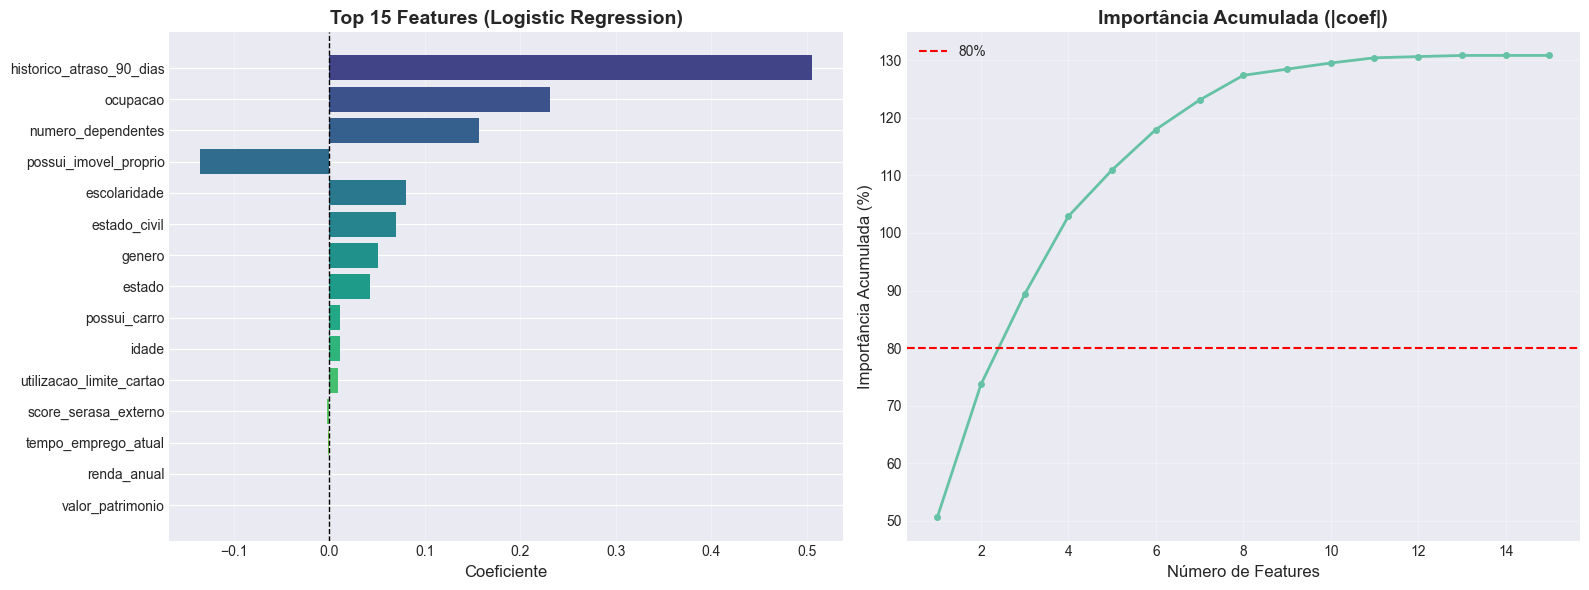


💾 Salvo: ../insights/feature_importance.csv


In [ ]:
# CÉLULA 16. FEATURE IMPORTANCE
print("⭐ FEATURE IMPORTANCE")

if melhor_modelo == 'Logistic Regression':

    modelo_lr = modelos['Logistic Regression']

    # Coeficientes (modelo binário)
    coeficientes = modelo_lr.coef_.ravel()

    df_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coeficiente': coeficientes,
        'Importância': np.abs(coeficientes)
    }).sort_values('Importância', ascending=False)
    
    print(f"\n🏆 TOP 15 FEATURES:")
    print(f"{'─'*60}")
    for _, row in df_importance.head(15).iterrows():
        print(f"{row['Feature']:30s}: {row['Coeficiente']:.4f}")    

    # Visualização
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 15 (equilíbrio entre legibilidade e cobertura)
    top_n = 15
    df_top = df_importance.head(top_n)

    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(df_top)))
    
    # Gráfico 1: Coeficientes
    axes[0].barh(range(len(df_top)), df_top['Coeficiente'], color=colors)
    axes[0].set_yticks(range(len(df_top)))
    axes[0].set_yticklabels(df_top['Feature'])
    axes[0].set_xlabel('Coeficiente', fontsize=12)
    axes[0].set_title(
        f'Top {top_n} Features (Logistic Regression)', 
        fontsize=14, fontweight='bold'
    )
    axes[0].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Gráfico 2: Importância acumulada
    df_importance['Acumulado'] = df_importance['Importância'].cumsum()
    
    axes[1].plot(
        range(1, len(df_importance) + 1),
        df_importance['Acumulado'] * 100,
        marker='o',
        linewidth=2,
        markersize=4
    )
    axes[1].axhline(80, color='red', linestyle='--', label='80%')
    axes[1].set_xlabel('Número de Features', fontsize=12)
    axes[1].set_ylabel('Importância Acumulada (%)', fontsize=12)
    axes[1].set_title('Importância Acumulada (|coef|)', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    # Salva relação
    df_importance.to_csv('../insights/feature_importance.csv', index=False)
    print("\n💾 Salvo: ../insights/feature_importance.csv")

In [ ]:
# CÉLULA 17. SALVAR MODELO E METADADOS
print("💾 SALVANDO MODELO E METADADOS")

# Salva modelo
modelo_final = melhor_modelo
joblib.dump(modelo_final, '../models/modelo_final.pkl')
print("✅ ../models/modelo_final.pkl")

# Metadados
metadados = {
    'modelo': melhor_modelo,
    'metricas': {
        'recall': float(resultados[melhor_modelo]['Recall']),
        'auc_roc': float(resultados[melhor_modelo]['AUC-ROC']),
        'f1_score': float(resultados[melhor_modelo]['F1-Score']),
        'precision': float(resultados[melhor_modelo]['Precision']),
        'accuracy': float(resultados[melhor_modelo]['Accuracy'])
    },
    'validacao_cruzada': {
        'recall_mean': float(scores_recall.mean()),
        'recall_std': float(scores_recall.std()),
        'auc_mean': float(scores_auc.mean()),
        'auc_std': float(scores_auc.std())
    },
    'features': X.columns.tolist(),
    'threshold_padrao': 0.5,
    'data_treino': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_treino': len(X_train),
    'total_teste': len(X_test),
    'taxa_inadimplencia_treino': float(y_train.mean()),
    'usa_normalizacao': melhor_modelo in ['KNN', 'Logistic Regression']
}

with open('../models/metadados_modelo.json', 'w', encoding='utf-8') as f:
    json.dump(metadados, f, indent=4, ensure_ascii=False)

print("✅ ../models/metadados_modelo.json")

💾 SALVANDO MODELO E METADADOS
✅ ../models/modelo_final.pkl
✅ ../models/metadados_modelo.json


In [ ]:
# CÉLULA 18. RESUMO FINAL
print("🎉 MODELAGEM CONCLUÍDA!")

print(f"""
🚨 MODELOS TREINADOS:
   • Random Forest
   • Logistic Regression
   • KNN

🏆 MELHOR MODELO: {melhor_modelo}
   Selecionado por: RECALL (detectar inadimplentes)
   
📊 PERFORMANCE:
   • Recall:    {resultados[melhor_modelo]['Recall']:.2%} ⭐ PRINCIPAL
   • AUC-ROC:   {resultados[melhor_modelo]['AUC-ROC']:.2%} ⭐ IMPORTANTE
   • F1-Score:  {resultados[melhor_modelo]['F1-Score']:.2%}
   • Precision: {resultados[melhor_modelo]['Precision']:.2%}
   • Accuracy:  {resultados[melhor_modelo]['Accuracy']:.2%}

🎯 VALIDAÇÃO CRUZADA (5-FOLD):
   • Recall: {scores_recall.mean():.2%} ± {scores_recall.std():.2%}
   • AUC-ROC: {scores_auc.mean():.2%} ± {scores_auc.std():.2%}

💡 TOP 3 FEATURES IMPORTANTES:
   1. {df_importance.iloc[0]['Feature']}: {df_importance.iloc[0]['Importância']:.4f}
   2. {df_importance.iloc[1]['Feature']}: {df_importance.iloc[1]['Importância']:.4f}
   3. {df_importance.iloc[2]['Feature']}: {df_importance.iloc[2]['Importância']:.4f}

💼 DIFERENCIAIS DO PROJETO:
   ✅ Foco em métricas de negócio (Recall > Accuracy)
   ✅ Curva ROC e AUC (obrigatório em crédito)
   ✅ Análise de threshold (decisão de negócio)
   ✅ Validação cruzada para confiabilidade
   ✅ Dados prontos para BI interativo

📌 INTERPRETAÇÃO PARA STAKEHOLDERS:
   "O modelo detecta {resultados[melhor_modelo]['Recall']*100:.0f}% dos inadimplentes,
   com AUC de {resultados[melhor_modelo]['AUC-ROC']:.2%} (excelente).
   As principais variáveis são: {df_importance.iloc[0]['Feature']}, 
   {df_importance.iloc[1]['Feature']} e {df_importance.iloc[2]['Feature']}."
""")

🎉 MODELAGEM CONCLUÍDA!

🚨 MODELOS TREINADOS:
   • Random Forest
   • Logistic Regression
   • KNN

🏆 MELHOR MODELO: Logistic Regression
   Selecionado por: RECALL (detectar inadimplentes)

📊 PERFORMANCE:
   • Recall:    66.95% ⭐ PRINCIPAL
   • AUC-ROC:   66.68% ⭐ IMPORTANTE
   • F1-Score:  39.13%
   • Precision: 27.65%
   • Accuracy:  60.01%

🎯 VALIDAÇÃO CRUZADA (5-FOLD):
   • Recall: 70.99% ± 0.82%
   • AUC-ROC: 77.06% ± 0.49%

💡 TOP 3 FEATURES IMPORTANTES:
   1. historico_atraso_90_dias: 0.5056
   2. ocupacao: 0.2311
   3. numero_dependentes: 0.1569

💼 DIFERENCIAIS DO PROJETO:
   ✅ Foco em métricas de negócio (Recall > Accuracy)
   ✅ Curva ROC e AUC (obrigatório em crédito)
   ✅ Análise de threshold (decisão de negócio)
   ✅ Validação cruzada para confiabilidade
   ✅ Dados prontos para BI interativo

📌 INTERPRETAÇÃO PARA STAKEHOLDERS:
   "O modelo detecta 67% dos inadimplentes,
   com AUC de 66.68% (excelente).
   As principais variáveis são: historico_atraso_90_dias, 
   ocupacao e 